# Building Multimodal Model

In [1]:
cd ..

/notebooks/MultimodalTweetsClassification


In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [4]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

In [5]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [8]:
#reading csv files and doing initial necessary processing
data_human_text_image,test_data_human_text_image = get_dataframe(*get_tsv_data_files('humanitarian_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [9]:
print(f"shape of data: {data_human_text_image.shape}\n")
print(f"train set: {data_human_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_human_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_human_text_image.shape}\n")

shape of data: (7124, 10)

train set: 6126
valid set: 998
shape of test data: (955, 9)



In [10]:
MODEL_CLASSES = {'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig)}

In [11]:
model_type = 'roberta'
pretrained_model_name = 'roberta-base'

In [12]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

In [15]:
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)
test_data_clas = get_test_text_data(test_data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)

# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [18]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = True
# print(config)

In [19]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(pad_idx,transformer_model = transformer_model)

In [20]:
CustomAdamW = partial(AdamW, correct_bias=False)

learn_clas = Learner(data_clas, custom_transformer_model,opt_func = CustomAdamW, 
                  metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [21]:
# print(learn_clas.model)

In [22]:
learn_clas.model.transformer = learn_clas.model.transformer.roberta
# print(learn_clas.model)

In [23]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_human_text_image,path,224)
test_data_img = get_test_image_data(test_data_human_text_image,path,224)

# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [24]:
# creating a learner object with image model to use it for concatenation 
arch = models.resnet50
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [25]:
# learn_img.model

In [26]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [27]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [28]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [29]:
#creating databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [30]:
(x1,x2),y = next(iter(data.test_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 89])
Shape dependent var: torch.Size([16])


In [31]:
lin_layers = [512+768, 5]
ps = 0.1
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps,with_transformer=True)

In [32]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()

layer_groups = [nn.Sequential(*(flatten_model(learn_clas.model.transformer.embeddings)+
                                flatten_model(learn_clas.model.transformer.encoder.layer[0])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[1])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[2])+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.encoder.layer[3])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[4])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[5])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[6])+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.encoder.layer[7])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[8])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[9])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[10])+
                                flatten_model(learn_clas.model.transformer.encoder.layer[11])+ 
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*(flatten_model(learn_clas.model.transformer.pooler)+
                   flatten_model(model.layers)))]

In [33]:
# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [34]:
len(learn.layer_groups)

4

In [51]:
learn.freeze()

In [53]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-02
Min loss divided by 10: 2.29E-03


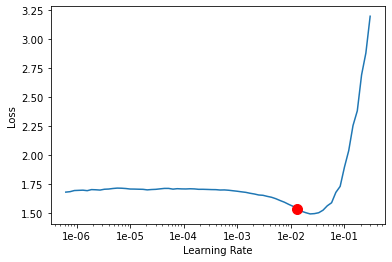

In [54]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,1.093507,0.866689,0.728457,0.544983,0.719311,0.529096,0.728457,0.536193,0.722819,00:36
1,1.067246,0.840426,0.735471,0.569078,0.744825,0.553780,0.735471,0.555185,0.733720,00:34
2,0.751990,0.717763,0.747495,0.555694,0.746941,0.582193,0.747495,0.567040,0.746326,00:34
3,0.571158,0.666077,0.760521,0.576940,0.756037,0.587152,0.760521,0.580954,0.757270,00:34
4,0.472802,0.678667,0.756513,0.568817,0.753082,0.585512,0.756513,0.576442,0.754331,00:34


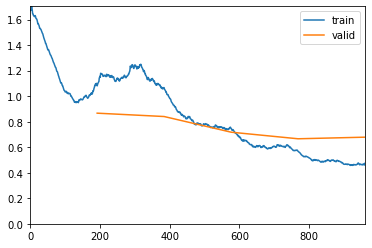

Better model found at epoch 0 with accuracy value: 0.7284569144248962.
Better model found at epoch 1 with accuracy value: 0.7354709506034851.
Better model found at epoch 2 with accuracy value: 0.7474949955940247.
Better model found at epoch 3 with accuracy value: 0.7605210542678833.


In [55]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(5,slice(1e-2), moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.622269,0.782669,0.741483,0.572377,0.742956,0.563437,0.741483,0.561129,0.737460,00:41
1,0.495885,0.731949,0.752505,0.583269,0.747441,0.563677,0.752505,0.570807,0.748277,00:41
2,0.334643,0.756116,0.765531,0.602244,0.760599,0.560903,0.765531,0.577918,0.758076,00:41


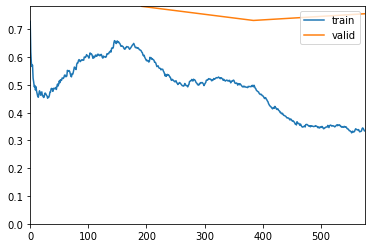

In [56]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.603145,0.823985,0.718437,0.558084,0.744525,0.544644,0.718437,0.544899,0.726963,00:50
1,0.425013,0.739578,0.763527,0.579252,0.764218,0.591471,0.763527,0.583226,0.762252,00:49
2,0.132715,0.741965,0.778557,0.608958,0.775292,0.586939,0.778557,0.595374,0.773534,00:49


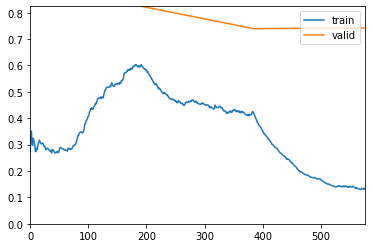

In [57]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


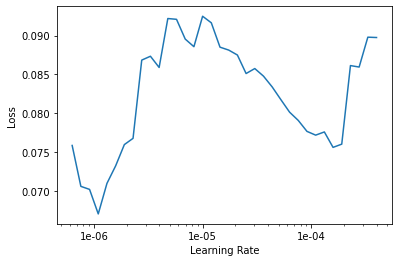

In [58]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.072017,0.738291,0.783567,0.611097,0.781895,0.602022,0.783567,0.604792,0.780413,01:00
1,0.078718,0.742463,0.785571,0.616591,0.780811,0.598905,0.785571,0.606606,0.781457,01:00


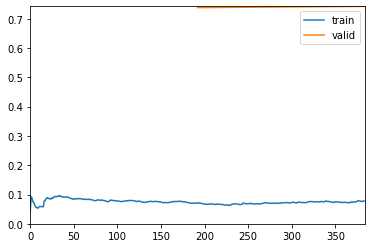

In [59]:
learn.fit_one_cycle(2, slice(5e-6/(2.6**4), 5e-6), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.073001,0.748598,0.783567,0.619966,0.778006,0.585586,0.783567,0.600468,0.777738,01:00
1,0.072500,0.733455,0.788577,0.616398,0.785519,0.602679,0.788577,0.608299,0.785258,01:01
2,0.076840,0.743825,0.781563,0.609556,0.777266,0.593031,0.781563,0.599933,0.777539,01:01
3,0.074946,0.758944,0.784569,0.621843,0.781239,0.586874,0.784569,0.601485,0.779111,01:00
4,0.066207,0.774794,0.786573,0.623989,0.784339,0.592738,0.786573,0.605618,0.781529,01:00


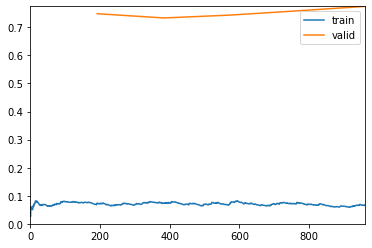

Better model found at epoch 0 with accuracy value: 0.7835671305656433.
Better model found at epoch 1 with accuracy value: 0.788577139377594.
Epoch 2: reducing lr to 6.112620219362893e-07


In [60]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-6/(2.6**4), 5e-6), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [61]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn)

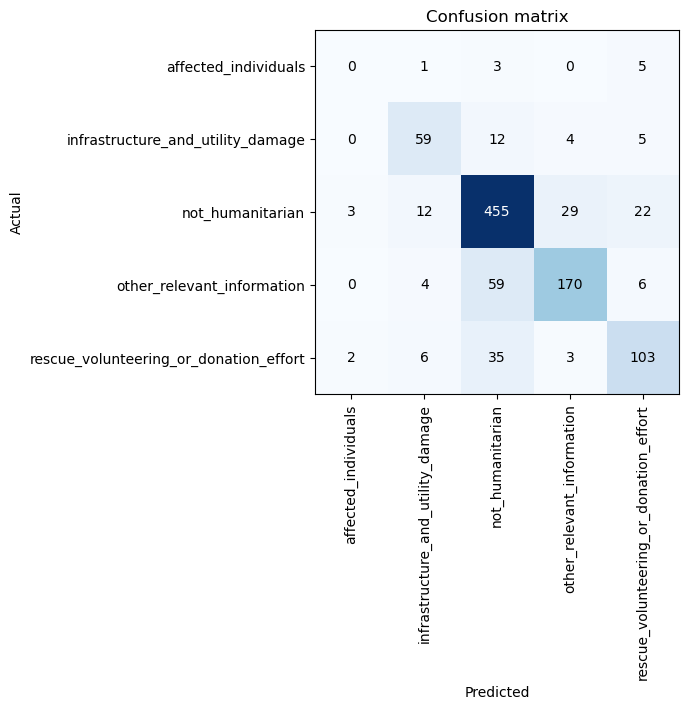

In [62]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)

In [63]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.73345506,
 tensor(0.7886),
 tensor(0.6164),
 tensor(0.7855),
 tensor(0.6027),
 tensor(0.7886),
 tensor(0.6083),
 tensor(0.7853)]

In [64]:
#making predictions on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.00      0.00      0.00         9
     infrastructure_and_utility_damage       0.72      0.74      0.73        80
                      not_humanitarian       0.81      0.87      0.84       521
            other_relevant_information       0.83      0.71      0.76       239
rescue_volunteering_or_donation_effort       0.73      0.69      0.71       149

                              accuracy                           0.79       998
                             macro avg       0.62      0.60      0.61       998
                          weighted avg       0.79      0.79      0.79       998



In [65]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.58119816,
 tensor(0.8021),
 tensor(0.8251),
 tensor(0.8027),
 tensor(0.6461),
 tensor(0.8021),
 tensor(0.6835),
 tensor(0.7969)]

In [66]:
#making predictions on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       1.00      0.22      0.36         9
     infrastructure_and_utility_damage       0.77      0.80      0.79        81
                      not_humanitarian       0.80      0.90      0.85       504
            other_relevant_information       0.87      0.75      0.81       235
rescue_volunteering_or_donation_effort       0.68      0.56      0.61       126

                              accuracy                           0.80       955
                             macro avg       0.83      0.65      0.68       955
                          weighted avg       0.80      0.80      0.80       955

